# Adaptively Sampled MPC

This is a simple demonstration of an adaptively sampled region quadtree used to approximate the solutions to a model-predictive control problem. 

In [1]:
using Pkg
pkg"activate ."

In [2]:
using RegionTrees
using StaticArrays: SVector
using Plots

In [3]:
# This module implements our MPC code, which consists of a 1-dimensional
# double-integrator system, forward-euler time-stepping dynamics, and a 
# 10 step prediction window. 

module mpc

using JuMP
using Gurobi
using StaticArrays
using Interpolations
using RegionTrees
import RegionTrees: AbstractRefinery, needs_refinement, refine_data

const env = Gurobi.Env()

# Solve the MPC problem from a given initial position and velocity
function run_mpc(q0, v0)
    model = Model(solver=GurobiSolver(env, OutputFlag=0))
    num_time_steps = 10
    dt = 0.1
    u_limit = 3
    C_q = 100
    c_vfinal = 100
    C_u = 1

    @variable model q[1:num_time_steps]
    @variable model v[1:num_time_steps]
    @variable model u[1:num_time_steps]

    @constraint model [i=2:num_time_steps] q[i] == q[i-1] + v[i-1] * dt
    @constraint model [i=2:num_time_steps] v[i] == v[i-1] + u[i-1] * dt
    @constraint model u .<= u_limit
    @constraint model u .>= -u_limit
    @constraint model q[1] == q0
    @constraint model v[1] == v0

    @objective model Min C_q * sum{q[i]^2, i=1:num_time_steps} + c_vfinal * v[end]^2 + C_u * sum{u[i]^2, i=1:num_time_steps}
    solve(model)

    getvalue(q), getvalue(v), getvalue(u)
end

# The MPCRefinery provides enough behavior to implement the 
# RegionTrees AdaptiveSampling interface, which lets us generate
# a quadtree of initial states and their corresponding MPC solutions.
struct MPCRefinery <: AbstractRefinery
end

function evaluate(cell, point)
    p = (point - cell.boundary.origin) ./ cell.boundary.widths
    cell.data(p[1] + 1, p[2] + 1)
end

# A cell in the quadtree needs refinement if its interpolated solution
# derived from its vertices is not a good fit for the true MPC solution
# at its center and the center of each of its faces
function needs_refinement(::MPCRefinery, cell)
    for x in body_and_face_centers(cell.boundary)
        value_interp = evaluate(cell, x)
        value_true = run_mpc(x[1], x[2])[3]
        if !isapprox(value_interp[1], value_true[1], rtol=1e-1, atol=1e-1)
            return true
        end
    end
    false
end

# The data element associated with a cell is a bilinear interpolation
# of the MPC function evaluated at the vertices of the cell.
function refine_data(r::MPCRefinery, cell::Cell, indices)
    refine_data(r, child_boundary(cell, indices))
end

function refine_data(::MPCRefinery, boundary::HyperRectangle)
    f = v -> run_mpc(v[1], v[2])[3]
    interpolate(f.(vertices(boundary)),
                BSpline(Linear()))
end

end

Academic license - for non-commercial use only


Main.mpc

In [4]:
# Simulate a given control function for the double integerator
# model.
function simulate(controller, q0, v0, dt, timespan)
    num_time_steps = timespan / dt
    qs = [q0]
    vs = [v0]
    ts = [0.0]
    q = q0
    v = v0
    for t in 0:dt:(timespan)
        u = controller(t, q, v)
        q += v * dt
        v += u * dt
        push!(qs, q)
        push!(vs, v)
        push!(ts, t)
    end
    ts, qs, vs
end
        

simulate (generic function with 1 method)

In [5]:
controller = (t, q, v) -> begin
    q, v, u = mpc.run_mpc(q, v)
    u[1]
end

#3 (generic function with 1 method)

In [6]:
t, q, v = simulate(controller, 10.0, 0.0, 0.1, 10)

([0.0, 0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8  …  9.1, 9.2, 9.3, 9.4, 9.5, 9.6, 9.7, 9.8, 9.9, 10.0], [10.0, 10.0, 9.97, 9.91, 9.82, 9.7, 9.55, 9.37, 9.16, 8.92  …  8.59724e-5, 5.36258e-5, 2.83979e-5, 9.84092e-6, -2.88847e-6, -1.08171e-5, -1.50039e-5, -1.64406e-5, -1.59925e-5, -1.43722e-5], [0.0, -0.3, -0.6, -0.9, -1.2, -1.5, -1.8, -2.1, -2.4, -2.7  …  -0.000323466, -0.000252279, -0.00018557, -0.000127294, -7.9286e-5, -4.18688e-5, -1.43665e-5, 4.48084e-6, 1.6203e-5, 2.23757e-5])

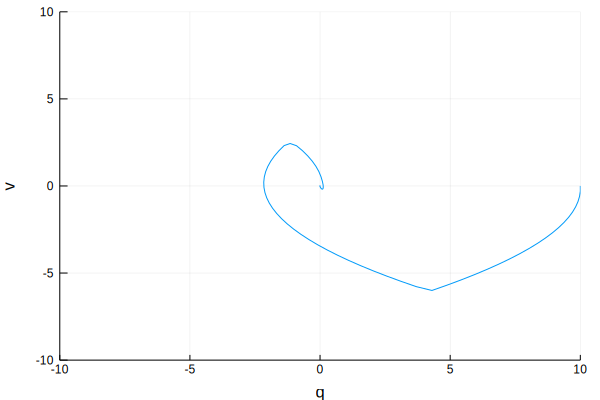

In [7]:
# State space portrait of the solution, starting from q=10, v=0
plot(q, v, xlim=(-10, 10), ylim=(-10, 10), xlabel="q", ylabel="v", legend=nothing)

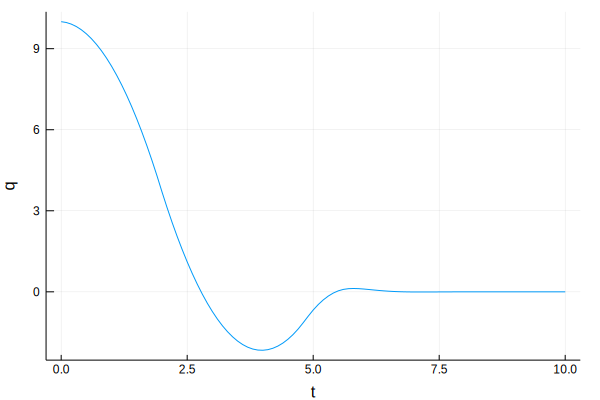

In [8]:
plot(t, q, xlabel="t", ylabel="q", legend=nothing)

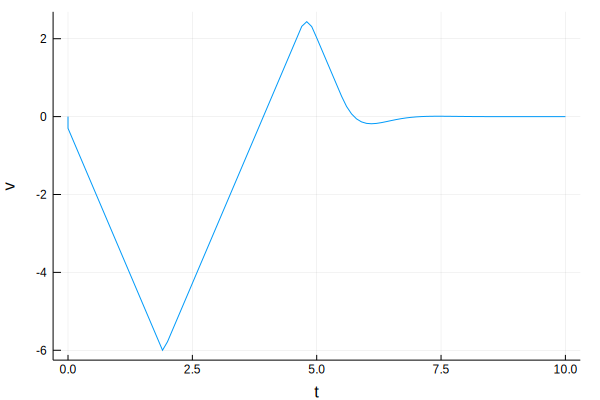

In [9]:
plot(t, v, xlabel="t", ylabel="v", legend=nothing)

# Approximating the solutions space
Now that we've written down and tested the true MPC solution, we can try to approximate it. The AdaptiveSampling() function will generate a quadtree by iteratively refining each cell in the space until the solutions to the MPC problem within that cell are well-approximated by the interpolation. 

In [10]:
boundary = RegionTrees.HyperRectangle(SVector(-10., -10), SVector(20., 20))
refinery = mpc.MPCRefinery()
root = RegionTrees.Cell(boundary, mpc.refine_data(refinery, boundary))
adaptivesampling!(root, refinery)

Cell: HyperRectangle{2,Float64}([-10.0, -10.0], [20.0, 20.0])

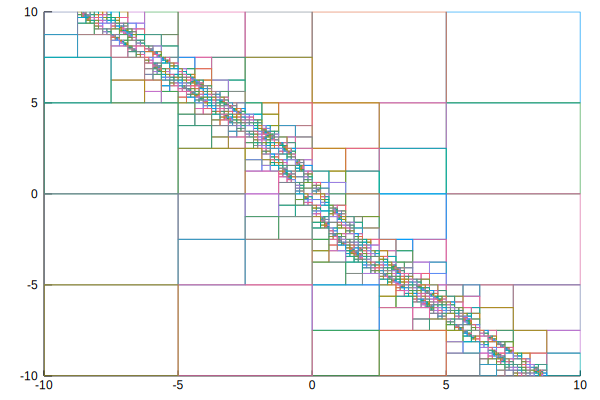

In [11]:
# Now we can plot each region in the quadtree. Note that we end up with
# a lot of detail along the switching surface from maximum acceleration
# to maximum deceleration
plt = plot(xlim=(-10, 10), ylim=(-10, 10), legend=nothing, grid=false)
for cell in RegionTrees.allleaves(root)
    v = hcat(collect(RegionTrees.vertices(cell.boundary))...)
    plot!(v[1,[1,2,4,3,1]], v[2,[1,2,4,3,1]])
end
plt

# Using the Approximate Solution
We can use the quadtree to produce an approximate controller for our system. Given the current state, we can look up the cell in the quadtree which encompasses that state, then use that cell's interpolation to find our control tape. 

In [12]:
approx_controller = (t, q, v) -> begin
    x = [q, v]
    leaf = RegionTrees.findleaf(root, x)
    u = mpc.evaluate(leaf, x)
    u[1]
end

#5 (generic function with 1 method)

In [13]:
t, q, v = simulate(approx_controller, 10.0, 0.0, 0.1, 10)

([0.0, 0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8  …  9.1, 9.2, 9.3, 9.4, 9.5, 9.6, 9.7, 9.8, 9.9, 10.0], [10.0, 10.0, 9.97, 9.91, 9.82, 9.7, 9.55, 9.37, 9.16, 8.92  …  9.99227e-5, 6.22194e-5, 3.28375e-5, 1.12446e-5, -3.55003e-6, -1.27489e-5, -1.75901e-5, -1.92311e-5, -1.86816e-5, -1.67721e-5], [0.0, -0.3, -0.6, -0.9, -1.2, -1.5, -1.8, -2.1, -2.4, -2.7  …  -0.000377034, -0.000293819, -0.000215929, -0.000147947, -9.1989e-5, -4.84113e-5, -1.64101e-5, 5.49477e-6, 1.90947e-5, 2.62314e-5])

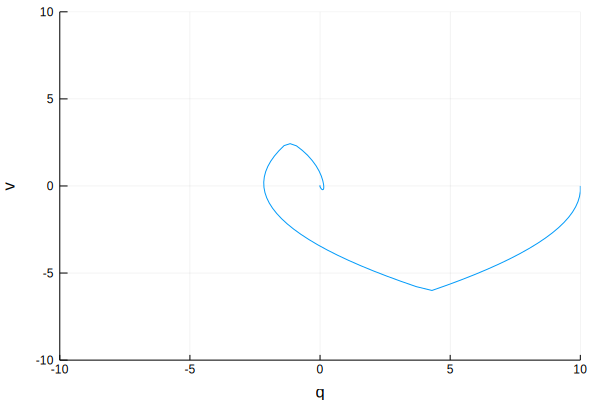

In [14]:
# The results are similar to, but not quite as good as, the 
# values obtained from the exact MPC solution. 
plot(q, v, xlim=(-10, 10), ylim=(-10, 10), xlabel="q", ylabel="v", legend=nothing)